## **Instalación de Liberías**
Se necesitará usar la libería *chembl_webresource_client*, necesaria para poder acceder a la base de datos de ChEMBL desde Python. Es necesario hacer uso del caracter admiración para usar los comandos mágicos a través de la consola de Unix.

In [ ]:
# instalar versión específica de itsdangerous para evitar conflictos
!pip install itsdangerous==2.1.2
!pip install chembl_webresource_client

## Importar las Librerías

In [ ]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
import seaborn as sb
# visualizar datos extensión collab
#data_table.enable_dataframe_formatter()
from google.colab import data_table
data_table.disable_dataframe_formatter()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings 
import re
import io
import matplotlib.cm as cm
from numpy import corrcoef, transpose, arange
from pylab import pcolor, show, colorbar, xticks, yticks
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## **Base a utilizar: ChEMBL**
Se utilizarán datos recuperados de la base de datos ChEMBL. Para más información ver [*Base de Datos de ChEMBL*](https://www.ebi.ac.uk/chembl/)

Se busca en objetivos o 'targets' la primera enfermedad, en este caso será leishmaniasis desde ChEMBL [*Query leishmaniasis desde ChEMBL*](https://www.ebi.ac.uk/chembl/g/#search_results/targets/query=lymphoma)



Información recuperada el 15 de agosto de 2021.

In [ ]:
leishmaniasis_trg = new_client.target
leishmaniasis_trgt_query = leishmaniasis_trg.search('leishmania') #leishmania entrada [3] lymphoma trypanosoma alzheimer
leishmaniasis_trgs = pd.DataFrame.from_dict(leishmaniasis_trgt_query)
leishmaniasis_trgs

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Leishmania,Leishmania,14.0,True,CHEMBL2366686,[],ORGANISM,5658
1,[],Leishmania,Cell membrane,13.0,True,CHEMBL4879388,[],SUBCELLULAR,38568
2,[],Leishmania infantum,Leishmania infantum,12.0,False,CHEMBL612848,[],ORGANISM,5671
3,[],Leishmania amazonensis,Leishmania amazonensis,12.0,False,CHEMBL612877,[],ORGANISM,5659
4,[],Leishmania braziliensis,Leishmania braziliensis,12.0,False,CHEMBL612878,[],ORGANISM,5660
5,[],Leishmania donovani,Leishmania donovani,12.0,False,CHEMBL367,[],ORGANISM,5661
6,[],Leishmania major,Leishmania major,12.0,False,CHEMBL612879,[],ORGANISM,5664
7,[],Leishmania mexicana,Leishmania mexicana,12.0,False,CHEMBL612880,[],ORGANISM,5665
8,[],Leishmania tropica,Leishmania tropica,12.0,False,CHEMBL612881,[],ORGANISM,5666
9,[],Leishmania aethiopica,Leishmania aethiopica,12.0,False,CHEMBL612651,[],ORGANISM,5667


In [ ]:
#leishmaniasis_trgs = leishmaniasis_trgs[leishmaniasis_trgs.organism == 'Homo sapiens']
#leishmaniasis_trgs.head(3) #leishmaniasis_trgs.head(10)

In [ ]:
print('Total registros: ', leishmaniasis_trgs.size, ' Dimension: ', leishmaniasis_trgs.shape)

Total registros:  540  Dimension:  (60, 9)


Se asigna la quinta entrada (que corresponde a la enfermedad objetivo) a la variable ***selected_target***

In [ ]:
#se prueban 4 primeras sin resultados asociados.
chembl_trg = leishmaniasis_trgs.target_chembl_id[3]  #leishmaniasis_trgs.target_chembl_id[5] 
chembl_trg

'CHEMBL612877'

Es necesario filtrar la información para que solo recupere datos con bioactividad IC50 para la primera enfermedad **target_chembl_id = 'CHEMBL4247'** que se muestran como valor de pChEMBL

In [ ]:
activity = new_client.activity
res_ic50 = activity.filter(target_chembl_id = chembl_trg).filter(standard_type="IC50")

Se convierte el array **res_ic50** resultado del comando anterior  en *DataFrame* de Pandas 

In [ ]:
df = pd.DataFrame.from_dict(res_ic50)

In [ ]:
df.to_csv('leishmaniasis_res_1.csv', index=False)

Ver nombre de Columnas

In [ ]:
# for col in df.columns:
#     print(col)
df.dtypes   

## **Proceso KDD**
Se eliminan registros vacíos en la columna **standard_value** y **canonical_smiles**.

In [ ]:
df.shape

(1961, 45)

In [ ]:
df = df[df.standard_value.notna()]
df = df[df.canonical_smiles.notna()]
df.shape

(1671, 45)

Se verifica la cantidad de registros únicos y luego se eliminan los duplicados

In [ ]:
len(df.canonical_smiles.unique())
df2_kdd = df.drop_duplicates(['canonical_smiles'])
df2_kdd

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,485873,[],CHEMBL709203,Inhibitory concentration against Leishmania am...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,mg ml-1,UO_0000274,None,0.48
1,None,554046,[],CHEMBL703515,In vitro inhibitory concentration against Leis...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,3.41
3,None,561069,[],CHEMBL703515,In vitro inhibitory concentration against Leis...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,1.14
5,None,564675,[],CHEMBL703515,In vitro inhibitory concentration against Leis...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,0.1
7,None,564700,[],CHEMBL703515,In vitro inhibitory concentration against Leis...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,10.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,None,23283686,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4837842,Antileishmanial activity against Leishmania am...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,93.85
1947,None,23283687,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4837842,Antileishmanial activity against Leishmania am...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,96.55
1948,None,23283688,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4837842,Antileishmanial activity against Leishmania am...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,123.25
1949,None,23283689,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4837842,Antileishmanial activity against Leishmania am...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,15.83


In [ ]:
df2_kdd.to_csv('matriz')
df2_kdd.pchembl_value.fillna(value=np.nan, inplace=True)

df2_kdd['pchembl_value'] = df2_kdd['pchembl_value'].fillna(0)
df2_kdd['potential_duplicate'] = df2_kdd['potential_duplicate'].fillna(0)

df2_kdd['document_year'] = df2_kdd['document_year'].fillna(2006)
df2_kdd['potential_duplicate'] = df2_kdd['potential_duplicate'].fillna(0)
df2_kdd['src_id'] = df2_kdd['src_id'].fillna(0)
df2_kdd['standard_flag'] = df2_kdd['standard_flag'].fillna(0)
df2_kdd['standard_value'] = df2_kdd['standard_value'].fillna(df2_kdd.mean())
df2_kdd['value'] = df2_kdd['value'].fillna(df2_kdd.mean())

#	df.fillna(df.mean())

df2_kdd

#df2_kdd['pchembl_value'].fillna(df2_kdd['pchembl_value'].mean(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,485873,[],CHEMBL709203,Inhibitory concentration against Leishmania am...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,mg ml-1,UO_0000274,None,0.48
1,None,554046,[],CHEMBL703515,In vitro inhibitory concentration against Leis...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,3.41
3,None,561069,[],CHEMBL703515,In vitro inhibitory concentration against Leis...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,1.14
5,None,564675,[],CHEMBL703515,In vitro inhibitory concentration against Leis...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,0.1
7,None,564700,[],CHEMBL703515,In vitro inhibitory concentration against Leis...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,10.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,None,23283686,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4837842,Antileishmanial activity against Leishmania am...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,93.85
1947,None,23283687,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4837842,Antileishmanial activity against Leishmania am...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,96.55
1948,None,23283688,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4837842,Antileishmanial activity against Leishmania am...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,123.25
1949,None,23283689,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4837842,Antileishmanial activity against Leishmania am...,F,None,None,BAO_0000190,BAO_0000218,...,Leishmania amazonensis,Leishmania amazonensis,5659,None,None,IC50,uM,UO_0000065,None,15.83


## Análisis de correlación

In [ ]:
columnas = df2_kdd[ (df2_kdd.columns).drop(['canonical_smiles', 'assay_chembl_id', 'assay_type', 'assay_description', 'activity_properties', 'activity_comment', 'activity_comment', 'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint', 'bao_format', 'bao_label', 'data_validity_comment', 'data_validity_description', 'document_chembl_id', 'document_journal', 'ligand_efficiency', 'molecule_chembl_id', 'molecule_pref_name', 'parent_molecule_chembl_id', 'qudt_units', 'record_id', 'relation', 'standard_relation', 'standard_text_value', 'standard_type', 'standard_units', 'standard_upper_value', 'target_chembl_id', 'target_organism', 'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type', 'units', 'uo_units', 'upper_value']) ].columns #upper_value

df2_kdd[columnas].isnull().any()
#columnas.isnull().any()

dft = df2_kdd[columnas].T

names =  dft.index
names


#dft = dft.applymap(str)


# #https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html
#R = corrcoef(dft)

# # http://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
# # Generate a mask for the upper triangle
# sns.set(style="white")
# mask = np.zeros_like(R, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True


# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(200, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(R, mask=mask, cmap=cmap, vmax=.8,
#             square=True, xticklabels=names, yticklabels=names,
#             linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Index(['activity_id', 'document_year', 'pchembl_value', 'potential_duplicate',
       'src_id', 'standard_flag', 'standard_value', 'value'],
      dtype='object')

Se unen las columnas más importantes en un solo dataset

In [ ]:
select_col = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_kdd[select_col]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL55,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,480.0
1,CHEMBL3138416,CC(O)(c1ccncc1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...,3410.0
3,CHEMBL3138308,CC(O)(c1ccccn1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...,1140.0
5,CHEMBL2069130,CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...,100.0
7,CHEMBL3138270,CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC...,10280.0
...,...,...,...
1946,CHEMBL4876767,COc1ccc(OC)c2c1Cn1cccc1C2(C)CC#N,93850.0
1947,CHEMBL4878509,CC1(CC#N)c2ccc(F)cc2Cn2cccc21,96550.0
1948,CHEMBL4870180,COc1ccc2c(c1)Cn1cccc1C2(C)CC#N,123250.0
1949,CHEMBL4871294,CC1(CC#N)c2ccc(OCc3ccccc3)cc2Cn2cccc21,15830.0


Ejemplo de verificación de diagrama de la segunda molécula

In [ ]:
!pip install rdkit
from rdkit import Chem
molecula_0 = Chem.MolFromSmiles(df['canonical_smiles'][0])

print(df['canonical_smiles'][0])
molecula_0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 331 kB/s 
N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1


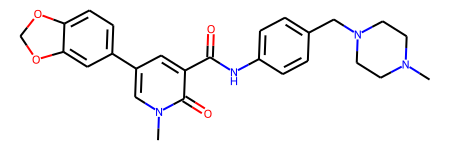

#Resetear índices

In [ ]:
df3.reset_index()
df3.to_csv('leishmaniasis_02_bioactivity_data_preprocessed.csv', index=False)

In [ ]:
df4 = pd.read_csv('leishmaniasis_02_bioactivity_data_preprocessed.csv')

### **Categorizar compuestos**
Los datos de bioactividad, consignados en la columna standard_value, están en unidades de IC50. Se clasifican estos valores en tres categorías. Los compuestos que tengan valores inferiores a 1.000 nM se considerarán **‘activos’**, Los valores entre 1.000 nM y 10.000 nM tendrán una categoría **‘NaN’** debido a que no se utilizarán, mientras que los valores superiores a 10.000 nM se considerarán **‘inactivos**’.

In [ ]:
import numpy as np

df4['valor_bioactividad'] = ''
df4['valor_bioactividad'] = np.where(df4['standard_value'] >= 10000, 'inactivo', np.where(df4['standard_value'] <= 1000, 'activo', 'NA'))
df4 = df4[(df4.valor_bioactividad == 'activo') | (df4.valor_bioactividad == 'inactivo')]
#reemplazar ceros con valor más pequeño
df4['standard_value'] = df4['standard_value'].replace(0.0, 0.06)

df4
#df4.drop(columns=['rango'])

,molecule_chembl_id,canonical_smiles,standard_value,valor_bioactividad
0,CHEMBL55,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,480.0,activo
3,CHEMBL2069130,CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...,100.0,activo
4,CHEMBL3138270,CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC...,10280.0,inactivo
12,CHEMBL66573,OC1(Cc2ccccc2)c2ccccc2C2=NCCN21,60.0,activo
13,CHEMBL303106,COc1ccc(C(=O)C(=O)c2ccccc2C(=O)N2CCCCC2)cc1OC,100.0,activo
...,...,...,...,...
1306,CHEMBL4876767,COc1ccc(OC)c2c1Cn1cccc1C2(C)CC#N,93850.0,inactivo
1307,CHEMBL4878509,CC1(CC#N)c2ccc(F)cc2Cn2cccc21,96550.0,inactivo
1308,CHEMBL4870180,COc1ccc2c(c1)Cn1cccc1C2(C)CC#N,123250.0,inactivo
1309,CHEMBL4871294,CC1(CC#N)c2ccc(OCc3ccccc3)cc2Cn2cccc21,15830.0,inactivo


In [ ]:
df4.to_csv('re_leishmaniasis.csv')

## Análisis de correlación

In [ ]:
df4.to_csv('leishmaniasis_03_bioactivity_data_curated.csv', index=False)

## PARTE 2: **Instalación de conda**

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
#@title
df = pd.read_csv('leishmaniasis_03_bioactivity_data_curated.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,valor_bioactividad
0,CHEMBL55,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,480.0,activo
1,CHEMBL2069130,CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...,100.0,activo
2,CHEMBL3138270,CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC...,10280.0,inactivo
3,CHEMBL66573,OC1(Cc2ccccc2)c2ccccc2C2=NCCN21,60.0,activo
4,CHEMBL303106,COc1ccc(C(=O)C(=O)c2ccccc2C(=O)N2CCCCC2)cc1OC,100.0,activo
...,...,...,...,...
989,CHEMBL4876767,COc1ccc(OC)c2c1Cn1cccc1C2(C)CC#N,93850.0,inactivo
990,CHEMBL4878509,CC1(CC#N)c2ccc(F)cc2Cn2cccc21,96550.0,inactivo
991,CHEMBL4870180,COc1ccc2c(c1)Cn1cccc1C2(C)CC#N,123250.0,inactivo
992,CHEMBL4871294,CC1(CC#N)c2ccc(OCc3ccccc3)cc2Cn2cccc21,15830.0,inactivo


Eliminar columna *canonical_smiles*

In [ ]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [ ]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,valor_bioactividad,canonical_smiles
0,CHEMBL55,480.0,activo,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1
1,CHEMBL2069130,100.0,activo,CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...
2,CHEMBL3138270,10280.0,inactivo,CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC...
3,CHEMBL66573,60.0,activo,OC1(Cc2ccccc2)c2ccccc2C2=NCCN21
4,CHEMBL303106,100.0,activo,COc1ccc(C(=O)C(=O)c2ccccc2C(=O)N2CCCCC2)cc1OC
...,...,...,...,...
989,CHEMBL4876767,93850.0,inactivo,COc1ccc(OC)c2c1Cn1cccc1C2(C)CC#N
990,CHEMBL4878509,96550.0,inactivo,CC1(CC#N)c2ccc(F)cc2Cn2cccc21
991,CHEMBL4870180,123250.0,inactivo,COc1ccc2c(c1)Cn1cccc1C2(C)CC#N
992,CHEMBL4871294,15830.0,inactivo,CC1(CC#N)c2ccc(OCc3ccccc3)cc2Cn2cccc21


Calcular descriptores de Lipinski
Christopher Lipinski, un científico de Pfizer, ideó un conjunto de reglas empíricas para evaluar la similitud de los compuestos con las drogas. Tal semejanza con las drogas se basa en la Absorción, Distribución, Metabolismo y Excreción (ADME), que también se conoce como perfil farmacocinético. Lipinski analizó todos los medicamentos activos por vía oral aprobados por la FDA en la formulación de lo que se conocerá como la regla de los cinco o la regla de Lipinski.

La Regla de Lipinski establecía lo siguiente:

Peso molecular < 500 Dalton
Coeficiente de reparto octanol-agua (LogP) < 5
Donantes de enlaces de hidrógeno < 5
Aceptores de enlaces de hidrógeno < 10

In [ ]:
"""
Lipinski:
    Moleculer Weight <= 500
    LogP <= 5
    H-Bond Donor Count <= 5
    H-Bond Acceptor Count <= 10
"""

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

Creación de la Función de Lipinski

In [ ]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["Peso_Molecular","LogP","Num_Donadores_H","Num_Aceptores"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df.canonical_smiles

0                N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1
1      CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...
2      CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC...
3                        OC1(Cc2ccccc2)c2ccccc2C2=NCCN21
4          COc1ccc(C(=O)C(=O)c2ccccc2C(=O)N2CCCCC2)cc1OC
                             ...                        
989                     COc1ccc(OC)c2c1Cn1cccc1C2(C)CC#N
990                        CC1(CC#N)c2ccc(F)cc2Cn2cccc21
991                       COc1ccc2c(c1)Cn1cccc1C2(C)CC#N
992               CC1(CC#N)c2ccc(OCc3ccccc3)cc2Cn2cccc21
993             COc1cc2c(cc1OCc1ccccc1)Cn1cccc1C2(C)CC#N
Name: canonical_smiles, Length: 994, dtype: object

In [ ]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski

,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores
0,340.427,2.88284,4.0,4.0
1,403.651,4.89930,3.0,3.0
2,573.979,8.57780,1.0,3.0
3,264.328,2.15020,1.0,3.0
4,381.428,3.39550,0.0,5.0
...,...,...,...,...
989,282.343,3.08668,0.0,4.0
990,240.281,3.20858,0.0,2.0
991,252.317,3.07808,0.0,3.0
992,328.415,4.64848,0.0,3.0


### **Unión de datasets**

Se unen los datasets

In [ ]:
df_combined = pd.concat([df_clean_smiles ,df_lipinski], axis=1)  #df_combined = pd.concat([df ,df_lipinski], axis=1) 
df_combined

,molecule_chembl_id,standard_value,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores
0,CHEMBL55,480.0,activo,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,340.427,2.88284,4.0,4.0
1,CHEMBL2069130,100.0,activo,CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...,403.651,4.89930,3.0,3.0
2,CHEMBL3138270,10280.0,inactivo,CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC...,573.979,8.57780,1.0,3.0
3,CHEMBL66573,60.0,activo,OC1(Cc2ccccc2)c2ccccc2C2=NCCN21,264.328,2.15020,1.0,3.0
4,CHEMBL303106,100.0,activo,COc1ccc(C(=O)C(=O)c2ccccc2C(=O)N2CCCCC2)cc1OC,381.428,3.39550,0.0,5.0
...,...,...,...,...,...,...,...,...
989,CHEMBL4876767,93850.0,inactivo,COc1ccc(OC)c2c1Cn1cccc1C2(C)CC#N,282.343,3.08668,0.0,4.0
990,CHEMBL4878509,96550.0,inactivo,CC1(CC#N)c2ccc(F)cc2Cn2cccc21,240.281,3.20858,0.0,2.0
991,CHEMBL4870180,123250.0,inactivo,COc1ccc2c(c1)Cn1cccc1C2(C)CC#N,252.317,3.07808,0.0,3.0
992,CHEMBL4871294,15830.0,inactivo,CC1(CC#N)c2ccc(OCc3ccccc3)cc2Cn2cccc21,328.415,4.64848,0.0,3.0


### **Convertir IC50 a pIC50**
Para permitir que los datos de **IC50** se distribuyan de manera más uniforme, convertiremos **IC50** a la escala logarítmica negativa que es esencialmente **-log10(IC50)**.

Esta función pIC50() recibe el dataset como parámetro de entrada.
* Toma el valor de IC50 desde la columna ``standard_value`` y la convierte desde nM a M y luego multiplica el valor por 10$^{-9}$
* Toma el valor molar y luego aplica el -log10
* Se borra la columna ``standard_value`` y se reemplaza por la columna ``pIC50``

In [ ]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_pic50']:
        molar = i*(10**-9)
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_pic50', 1)
        
    return x

In [ ]:
df_combined.standard_value.describe()

count    9.940000e+02
mean     2.718600e+05
std      2.097099e+06
min      6.000000e-02
25%      9.000000e+02
50%      2.525000e+04
75%      9.418750e+04
max      5.000345e+07
Name: standard_value, dtype: float64

In [ ]:
#Los valores superiores a 100 000 000 se fijarán en 100 000 000; de lo contrario, el valor logarítmico negativo se volverá negativo.
-np.log10( (10**-9)* 100000000 )
-np.log10( (10**-9)* 100000000 )

1.0

In [ ]:
def normalizar_pic50(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_pic50'] = norm
    x = input.drop('standard_value', 1)
        
    return x

Primero aplicaremos la función norm_value() para que los valores en la columna standard_value se normalicen.

In [ ]:
df_pic50 = normalizar_pic50(df_combined)
df_pic50

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,standard_value_pic50
0,CHEMBL55,activo,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,340.427,2.88284,4.0,4.0,480.0
1,CHEMBL2069130,activo,CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...,403.651,4.89930,3.0,3.0,100.0
2,CHEMBL3138270,inactivo,CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC...,573.979,8.57780,1.0,3.0,10280.0
3,CHEMBL66573,activo,OC1(Cc2ccccc2)c2ccccc2C2=NCCN21,264.328,2.15020,1.0,3.0,60.0
4,CHEMBL303106,activo,COc1ccc(C(=O)C(=O)c2ccccc2C(=O)N2CCCCC2)cc1OC,381.428,3.39550,0.0,5.0,100.0
...,...,...,...,...,...,...,...,...
989,CHEMBL4876767,inactivo,COc1ccc(OC)c2c1Cn1cccc1C2(C)CC#N,282.343,3.08668,0.0,4.0,93850.0
990,CHEMBL4878509,inactivo,CC1(CC#N)c2ccc(F)cc2Cn2cccc21,240.281,3.20858,0.0,2.0,96550.0
991,CHEMBL4870180,inactivo,COc1ccc2c(c1)Cn1cccc1C2(C)CC#N,252.317,3.07808,0.0,3.0,123250.0
992,CHEMBL4871294,inactivo,CC1(CC#N)c2ccc(OCc3ccccc3)cc2Cn2cccc21,328.415,4.64848,0.0,3.0,15830.0


In [ ]:
df_pic50.standard_value_pic50.describe()

count    9.940000e+02
mean     2.718600e+05
std      2.097099e+06
min      6.000000e-02
25%      9.000000e+02
50%      2.525000e+04
75%      9.418750e+04
max      5.000345e+07
Name: standard_value_pic50, dtype: float64

In [ ]:
df_final = pIC50(df_pic50)
df_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':


,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,pIC50
0,CHEMBL55,activo,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,340.427,2.88284,4.0,4.0,6.318759
1,CHEMBL2069130,activo,CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...,403.651,4.89930,3.0,3.0,7.000000
2,CHEMBL3138270,inactivo,CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC...,573.979,8.57780,1.0,3.0,4.988007
3,CHEMBL66573,activo,OC1(Cc2ccccc2)c2ccccc2C2=NCCN21,264.328,2.15020,1.0,3.0,7.221849
4,CHEMBL303106,activo,COc1ccc(C(=O)C(=O)c2ccccc2C(=O)N2CCCCC2)cc1OC,381.428,3.39550,0.0,5.0,7.000000
...,...,...,...,...,...,...,...,...
989,CHEMBL4876767,inactivo,COc1ccc(OC)c2c1Cn1cccc1C2(C)CC#N,282.343,3.08668,0.0,4.0,4.027566
990,CHEMBL4878509,inactivo,CC1(CC#N)c2ccc(F)cc2Cn2cccc21,240.281,3.20858,0.0,2.0,4.015248
991,CHEMBL4870180,inactivo,COc1ccc2c(c1)Cn1cccc1C2(C)CC#N,252.317,3.07808,0.0,3.0,3.909213
992,CHEMBL4871294,inactivo,CC1(CC#N)c2ccc(OCc3ccccc3)cc2Cn2cccc21,328.415,4.64848,0.0,3.0,4.800519


In [ ]:
df_final.pIC50.describe()

count    994.000000
mean       5.015429
std        1.465172
min        1.301000
25%        4.026008
50%        4.597739
75%        6.045757
max       10.221849
Name: pIC50, dtype: float64

In [ ]:
df_final.to_csv('leishmaniasis_04_bioactivity_data_3class_pIC50.csv')

### **Eliminar valores NaN de la columna valor_bioactividad**
Aquí, eliminaremos el valor ``NaN`` de nuestro conjunto de datos.

In [ ]:
df2 = df_final.dropna()
df2.reset_index()
df2.to_csv('prueba_1.csv', index = False)
df2

,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,pIC50
0,CHEMBL55,activo,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,340.427,2.88284,4.0,4.0,6.318759
1,CHEMBL2069130,activo,CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...,403.651,4.89930,3.0,3.0,7.000000
2,CHEMBL3138270,inactivo,CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC...,573.979,8.57780,1.0,3.0,4.988007
3,CHEMBL66573,activo,OC1(Cc2ccccc2)c2ccccc2C2=NCCN21,264.328,2.15020,1.0,3.0,7.221849
4,CHEMBL303106,activo,COc1ccc(C(=O)C(=O)c2ccccc2C(=O)N2CCCCC2)cc1OC,381.428,3.39550,0.0,5.0,7.000000
...,...,...,...,...,...,...,...,...
989,CHEMBL4876767,inactivo,COc1ccc(OC)c2c1Cn1cccc1C2(C)CC#N,282.343,3.08668,0.0,4.0,4.027566
990,CHEMBL4878509,inactivo,CC1(CC#N)c2ccc(F)cc2Cn2cccc21,240.281,3.20858,0.0,2.0,4.015248
991,CHEMBL4870180,inactivo,COc1ccc2c(c1)Cn1cccc1C2(C)CC#N,252.317,3.07808,0.0,3.0,3.909213
992,CHEMBL4871294,inactivo,CC1(CC#N)c2ccc(OCc3ccccc3)cc2Cn2cccc21,328.415,4.64848,0.0,3.0,4.800519


In [ ]:
df2.to_csv('leishmaniasis_05_bioactivity_data_2class_pIC50.csv')

## **Análisis de datos exploratorios (Análisis del espacio químico) a través del descriptor de Lipinski**

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Diagrama de frecuencias para las dos categorías**


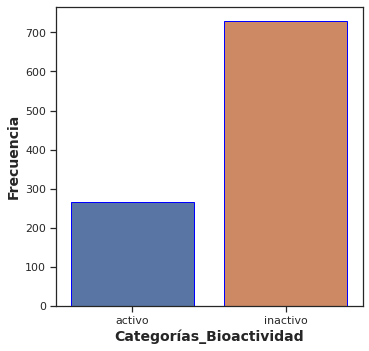

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='valor_bioactividad', data=df2, edgecolor='blue') #facecolor='blue'

plt.xlabel('Categorías_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('Frecuencia', fontsize=14, fontweight='bold')

plt.savefig('grafica_categorias_bioactividad.pdf')

([<matplotlib.patches.Wedge at 0x7fcc38d4d8d0>,
 [Text(0.7362158976171015, 0.8173041980167761, 'activo'),
  Text(-0.7362158976171015, -0.8173041980167761, 'inactivo')],
 [Text(0.4015723077911462, 0.4458022898273324, '26.7%'),
  Text(-0.4015723077911462, -0.4458022898273324, '73.3%')])

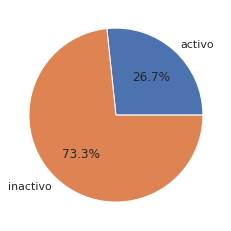

In [ ]:
#Se construye un pie para establecer el porcentaje de cada catergoría en las clases 
#Se definen los totales para cada categoría 
inactive=265
active=729
conteos=[inactive,active]
clase=['activo','inactivo']
plt.pie(conteos,labels=clase,startangle=0,autopct='%1.1f%%')

### **Diagrama de puntos Peso_Molecular vs LogP**

Puede verse que las 2 categorías de bioactividad abarcan espacios químicos similares, como lo demuestra el diagrama de dispersión de Peso_Molecular frente a LogP.

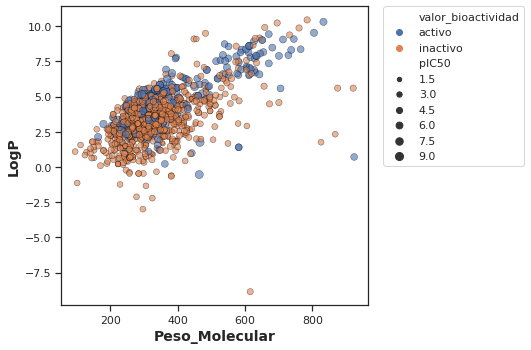

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='Peso_Molecular', y='LogP', data=df2, hue='valor_bioactividad', size='pIC50', edgecolor='black', alpha=0.6, facecolor = 'red')

plt.xlabel('Peso_Molecular', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_Peso_Molecular_vs_LogP.pdf')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


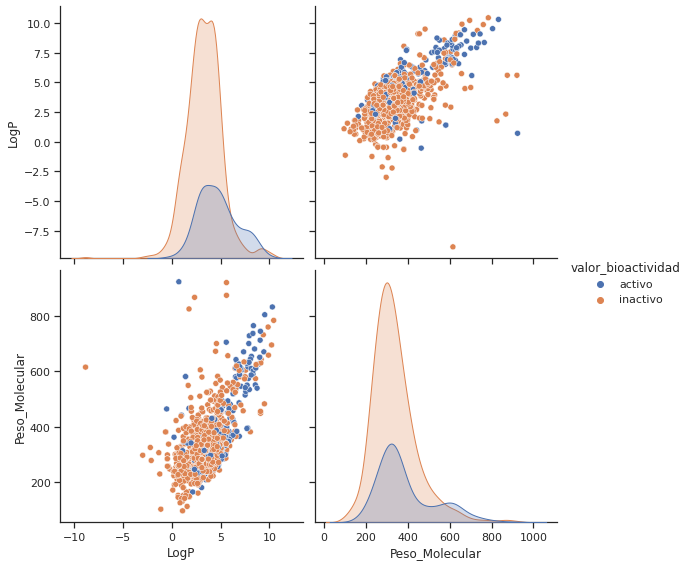

In [ ]:
sb.pairplot(df2.dropna(),hue='valor_bioactividad',size=4,vars=["LogP","Peso_Molecular"],kind="scatter")

### **Box plots**
#### **PIC50**

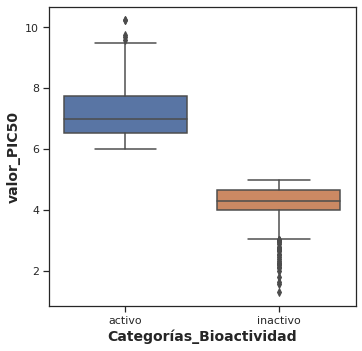

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'valor_bioactividad', y = 'pIC50', data = df2)

plt.xlabel('Categorías_Bioactividad', fontsize=14, fontweight='bold', )
plt.ylabel('valor_PIC50', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [ ]:
#histogramas para la variable MW
#Ahora se procede a contruir los ejes
#número de breaks en el histograma
df_2_activo = df2[df2['valor_bioactividad']=='activo']
df_2_inactivo = df2[df2['valor_bioactividad']=='inactivo']

#### **Peso_Molecular**

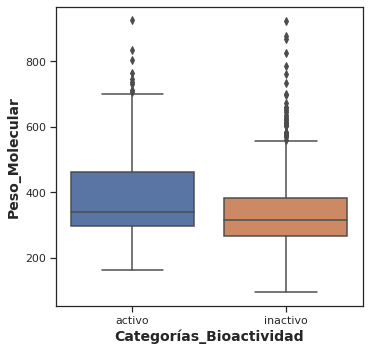

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'valor_bioactividad', y = 'Peso_Molecular', data = df2)

plt.xlabel('Categorías_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('Peso_Molecular', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

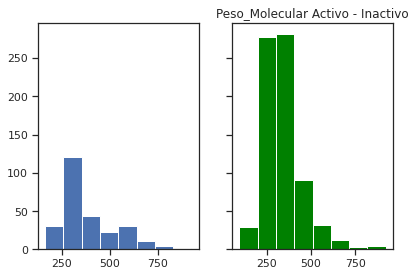

In [ ]:
n_bins = 8
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#gráfica del histograma usuarios activos
axs[0].hist(df_2_activo['Peso_Molecular'], bins=n_bins)
#gráfica del histograma usuarios inactivos
axs[1].hist(df_2_inactivo['Peso_Molecular'], bins=n_bins,color='green')
plt.title('Peso_Molecular Activo - Inactivo', loc='center')
plt.show()

#### **LogP**

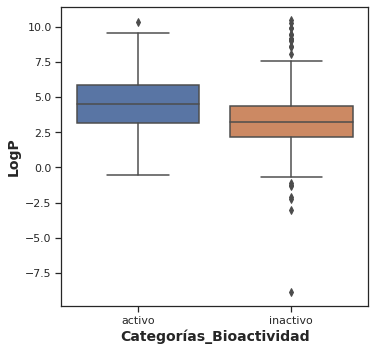

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'valor_bioactividad', y = 'LogP', data = df2)

plt.xlabel('Categorías_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

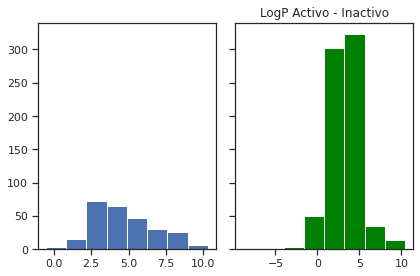

In [ ]:
n_bins = 8
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#gráfica del histograma usuarios activos
axs[0].hist(df_2_activo['LogP'], bins=n_bins)
#gráfica del histograma usuarios inactivos
axs[1].hist(df_2_inactivo['LogP'], bins=n_bins,color='green')
plt.title('LogP Activo - Inactivo')
plt.show()

#### **Num_Donadores_Hidrógeno**

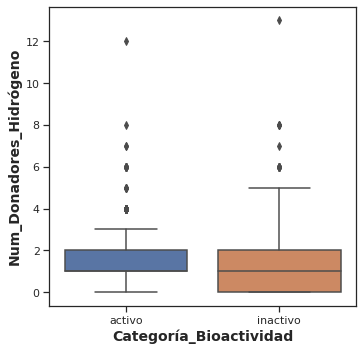

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'valor_bioactividad', y = 'Num_Donadores_H', data = df2)

plt.xlabel('Categoría_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('Num_Donadores_Hidrógeno', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

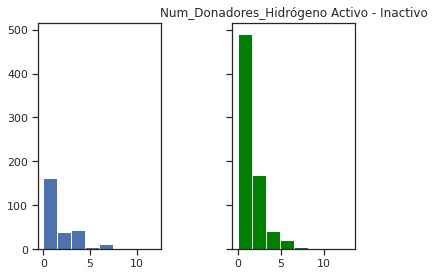

In [ ]:
n_bins = 8
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#gráfica del histograma usuarios activos
axs[0].hist(df_2_activo['Num_Donadores_H'], bins=n_bins)
#gráfica del histograma usuarios inactivos
axs[1].hist(df_2_inactivo['Num_Donadores_H'], bins=n_bins,color='green')
plt.title('Num_Donadores_Hidrógeno Activo - Inactivo')
plt.show()

#### **Num_Aceptores**

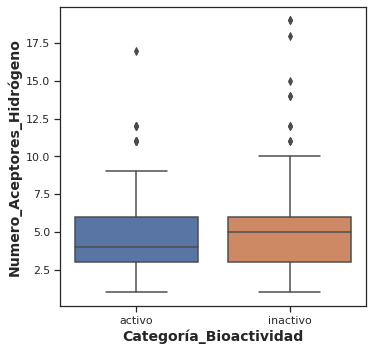

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'valor_bioactividad', y = 'Num_Aceptores', data = df2)

plt.xlabel('Categoría_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('Numero_Aceptores_Hidrógeno', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

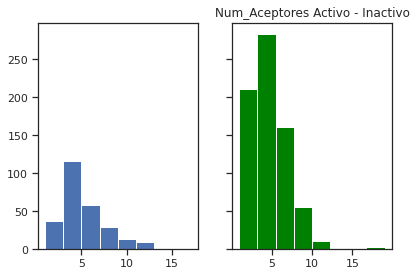

In [ ]:
n_bins = 8
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#gráfica del histograma usuarios activos
axs[0].hist(df_2_activo['Num_Aceptores'], bins=n_bins)
#gráfica del histograma usuarios inactivos
axs[1].hist(df_2_inactivo['Num_Aceptores'], bins=n_bins,color='green')
plt.title('Num_Aceptores Activo - Inactivo')
plt.show()

In [ ]:
from rdkit.Chem import Descriptors
from rdkit.Chem import MolFromSmiles

mols = []

for i in df2.canonical_smiles:
        mol = MolFromSmiles(i)
        mols.append(mol)
        #print(df2)
ID = df2.molecule_chembl_id
STATUS = df2.valor_bioactividad
MW = [Descriptors.MolWt(n) for n in mols]
LogP = [Descriptors.MolLogP(o) for o in mols]
nHAcc = [Descriptors.NumHAcceptors(p) for p in mols]
nHDon = [Descriptors.NumHDonors(q) for q in mols]

data = pd.DataFrame(
    {'molecule_chembl_id': ID,
     'STATUS' : STATUS,
     'MW': MW, 
     'LogP': LogP,
     'nHAcc': nHAcc,
     'nHDon': nHDon
    })
data = data[['molecule_chembl_id','STATUS','MW','LogP','nHAcc','nHDon']]

In [ ]:
df2.head(1)

,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,pIC50
0,CHEMBL55,activo,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,340.427,2.88284,4.0,4.0,6.318759


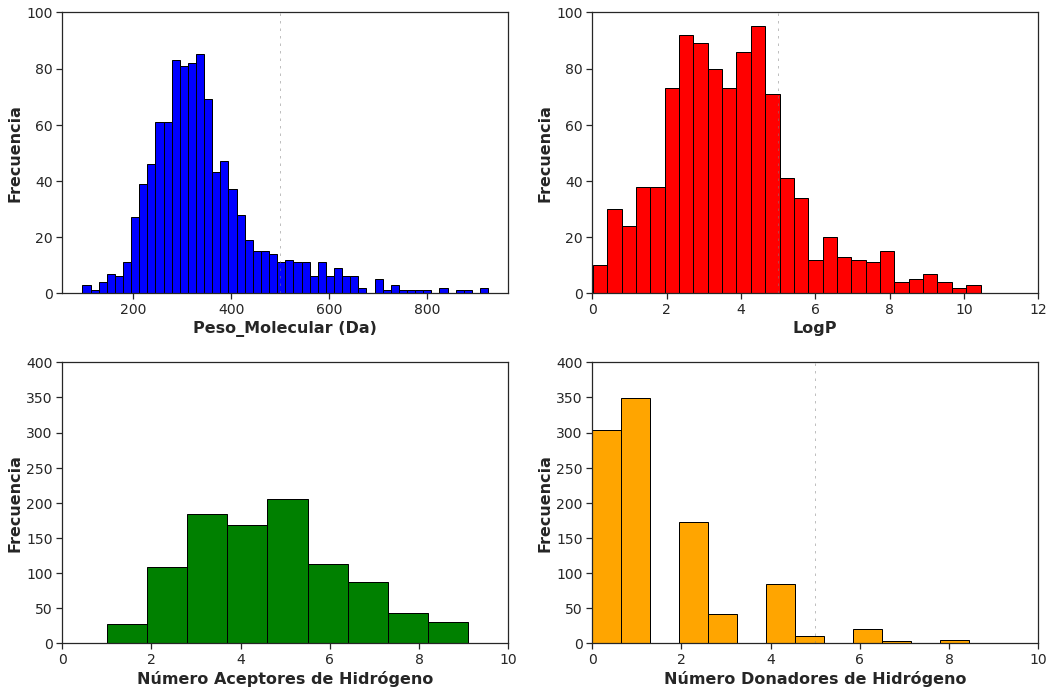

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

figure, ((plt1,plt2), (plt3,plt4)) = plt.subplots(2, 2)
figure.set_size_inches(15,10)

# Histograma para MW
hist, bins = np.histogram(MW, 50)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt1.bar(center, hist, align='center', width=width, color='blue',edgecolor='black',\
         error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2,linestyle='-', linewidth=0.5))
plt1.set_xlabel('Peso_Molecular (Da)', fontsize=16, fontweight='bold')
plt1.set_ylabel('Frecuencia', fontsize=16, fontweight='bold')
plt1.tick_params(axis='both', which='major', labelsize=14)
#plt1.set_xlim(200,900)
plt1.set_ylim(0, 100)
#plt1.grid(True)
plt1.axvline(500, color='gray',linestyle='--', dashes=(5, 10), linewidth=0.5)

# Histograma para LogP
hist, bins = np.histogram(LogP, 50)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt2.bar(center, hist, align='center', width=width, color='red',edgecolor='black',\
         error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2,linestyle='-', linewidth=0.5))
plt2.set_xlabel('LogP', fontsize=16, fontweight='bold')
plt2.set_ylabel('Frecuencia', fontsize=16, fontweight='bold')
plt2.tick_params(axis='both', which='major', labelsize=14)
plt2.set_xlim(0,12)
plt2.set_ylim(0,100)
plt2.axvline(5, color='gray',linestyle='--', dashes=(5, 10), linewidth=0.5)

# Histograma para nHDon
hist, bins = np.histogram(nHDon, 20)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt4.bar(center, hist, align='center', width=width, color='orange',edgecolor='black',\
         error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2, linestyle='-', linewidth=0.5))
plt4.set_xlabel('Número Donadores de Hidrógeno', fontsize=16, fontweight='bold')
plt4.set_ylabel('Frecuencia', fontsize=16, fontweight='bold')
plt4.tick_params(axis='both', which='major', labelsize=14)
plt4.set_xlim(0,10)
plt4.set_ylim(0,400)
#plt4.grid(True)
plt4.axvline(5, color='gray',linestyle='--', dashes=(5, 10), linewidth=0.5)

# Histograma para nHAcc
hist, bins = np.histogram(nHAcc, 20)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt3.bar(center, hist, align='center', width=width, color='green',edgecolor='black',\
         error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2, linestyle='-', linewidth=0.5))
plt3.set_xlabel('Número Aceptores de Hidrógeno', fontsize=16, fontweight='bold')
plt3.set_ylabel('Frecuencia', fontsize=16, fontweight='bold')
plt3.tick_params(axis='both', which='major', labelsize=14)
plt3.set_xlim(0,10)
plt3.set_ylim(0,400)
#plt3.grid(True)
plt3.axvline(10, color='gray',linestyle='--', dashes=(5, 10), linewidth=0.5)

plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/dis

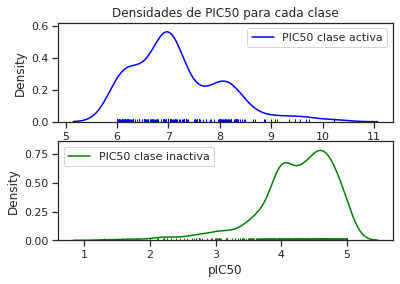

In [ ]:
#Gráficas de densidad para cada medición PIC50 (Estimación Kernel)
plt.figure()
plt.subplot(2, 1,1)
plt.title('Densidades de PIC50 para cada clase')
ax = sns.distplot(df_2_activo['pIC50'], rug=True, hist=False,label='PIC50 clase activa',color='blue')
plt.legend()
plt.subplot(2, 1,2)
ax = sns.distplot(df_2_inactivo['pIC50'], rug=True, hist=False,label='PIC50 clase inactiva',color='green')
plt.legend()
plt.show()

## Análisis inferencial

En esta sección se van a analizar inferencialmnete  a la variable *PIC50* para la clase activo e inactivo. Por lo tanto, se cargan las siguientes librerías



In [ ]:
#Se carga las librerías requeridas 
import statsmodels.api as sm
from scipy import stats

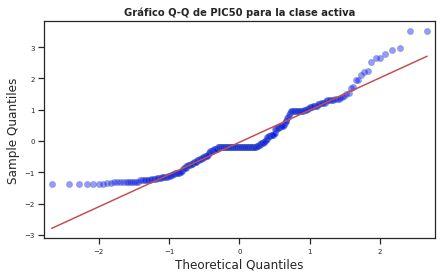

In [ ]:
#Se va a construir los QQ-plot para  'PIC50' en cada una de las  clases
#Esto se hace con el objetivo de analizar si los cuantiles teóricos ccoinciden con los cuantiles muestrales 
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(df_2_activo['pIC50'],fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q de PIC50 para la clase activa', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)

Antes de empezar con un resultado formal, s epuede analizar el QQ-plot para 
analizar si los cuantiles o percentiles muestrales coinciden con los cuantiles teóricos de la distribución normal 

Se puede apreciar que  empíricamente los cuantiles muestrales de **PIC50** de la clase **activa** no se ajustan bien a los cuantiles teóricos de la distribución normal 

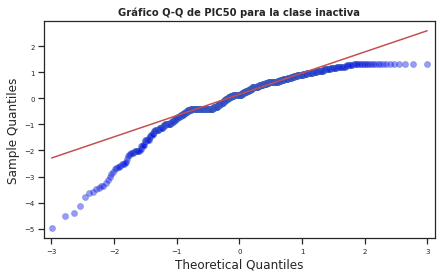

In [ ]:
#Se va a construir los QQ-plot para  'PIC50' en cada una de las  clases
#Esto se hace con el objetivo de analizar si los cuantiles teóricos ccoinciden con los cuantiles muestrales 
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(df_2_inactivo['pIC50'],fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q de PIC50 para la clase inactiva', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)

Se puede apreciar que  empíricamente los cuantiles muestrales de **PIC50** de la clase **inactiva** no se ajustan bien a los cuantiles teóricos de la distribución normal 

In [ ]:
# Test de Shapiro-Wilk  (clase activa)
# ==============================================================================
shapiro_test = stats.shapiro(df_2_activo['pIC50'])
shapiro_test

ShapiroResult(statistic=0.9237006306648254, pvalue=2.0494833607997975e-10)

En este caso el $$p-valor=2.0494833607997975*10^{-10}$$ 
Luego, a un nivel de significancia de $$\alpha=0.05$$
Se tiene que: $$p-valor=2.0494833607997975*10^{-10}<0.05=\alpha$$
Por lo tanto, se rechaza la hipótesis  nula. Es decir, que como se había apreciada empíricamente la muestra no viene de una población con distribución normal. Por lo tanto, existe evidencia estadística para deducir que la variable **PIC50** de la clase activa no tiene una distribución normal.

**Mann-Whitney U Test**

In [ ]:
# Test de Shapiro-Wilk  (clase inactiva)
# ==============================================================================
shapiro_test = stats.shapiro(df_2_inactivo['pIC50'])
shapiro_test

ShapiroResult(statistic=0.8927207589149475, pvalue=4.0979675622484013e-22)

En este caso el $$p-valor=4.0979675622484013*10^{-22}$$ 
Luego, a un nivel de significancia de $$\alpha=0.05$$
Se tiene que: $$p-valor=4.0979675622484013*10^{-22}<0.05=\alpha$$
Por lo tanto, se rechaza la hipótesis  nula. Es decir, que como se había apreciada empíricamente la muestra no viene de una población con distribución normal. Por lo tanto, existe evidencia estadística para deducir que la variable **PIC50** de la clase activa no tiene una distribución normal.

##Mannwhitney

Teniendo en cuenta que se mostró que ninguna de las poblaciones es normal, no se puede aplicar el t-test para la diferencia de medias poblacionales puesto que este test exige que las muestras provengas de poblaciones normales que en este caso no se cumple. Teniendo esto en cuenta se va a usar un test no paramétrico donde lo supuestos poblacionales son mucho más flexibles al respeto y permite discernir si las distribuciones son iguales o no 

In [ ]:
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# Semilla
  seed(1)

# Activos e Inactivos
  selection = [descriptor, 'valor_bioactividad']
  df = df2[selection]
  activo = df[df['valor_bioactividad'] == 'activo']
  activo = activo[descriptor]

  selection = [descriptor, 'valor_bioactividad']
  df = df2[selection]
  inactivo = df[df['valor_bioactividad'] == 'inactivo']
  inactivo = inactivo[descriptor]

# Categorías
  stat, p = mannwhitneyu(activo, inactivo)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

  alpha = 0.05
  if p > alpha:
    resultado = 'Misma distribución (no rechazar H0)'
  else:
    resultado = 'Diferente distribución (rechazar H0)'
  
  results = pd.DataFrame({'Variable':descriptor,
                          'Resultado':stat,
                          'p-value':p,
                          'alpha':alpha,
                          'Interpretación':resultado}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

,Variable,Resultado,p-value,alpha,Interpretación
0,pIC50,193185.0,8.634457e-129,0.05,Diferente distribución (rechazar H0)


In [ ]:
mannwhitney('Peso_Molecular')

,Variable,Resultado,p-value,alpha,Interpretación
0,Peso_Molecular,117113.0,2.942732e-07,0.05,Diferente distribución (rechazar H0)


In [ ]:
mannwhitney('LogP')

,Variable,Resultado,p-value,alpha,Interpretación
0,LogP,134124.0,6.761610e-21,0.05,Diferente distribución (rechazar H0)


In [ ]:
mannwhitney('Num_Donadores_H')

,Variable,Resultado,p-value,alpha,Interpretación
0,Num_Donadores_H,109134.0,0.001104,0.05,Diferente distribución (rechazar H0)


In [ ]:
mannwhitney('Num_Aceptores')

,Variable,Resultado,p-value,alpha,Interpretación
0,Num_Aceptores,88112.0,0.032035,0.05,Diferente distribución (rechazar H0)


## **Zip files**

In [ ]:
# Test de Shapiro-Wilk  (clase inactiva)
# ==============================================================================
shapiro_test = stats.shapiro(df_2_inactivo['pIC50'])
shapiro_test

ShapiroResult(statistic=0.8927207589149475, pvalue=4.0979675622484013e-22)

In [ ]:
! zip -r results.zip . -i *.csv *.pdf

  adding: leishmaniasis_res_1.csv (deflated 93%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: mannwhitneyu_Num_Donadores_H.csv (deflated 7%)
  adding: leishmaniasis_04_bioactivity_data_3class_pIC50.csv (deflated 74%)
  adding: re_leishmaniasis.csv (deflated 79%)
  adding: mannwhitneyu_Peso_Molecular.csv (deflated 6%)
  adding: plot_NumHDonors.pdf (deflated 36%)
  adding: mannwhitneyu_pIC50.csv (deflated 6%)
  adding: plot_NumHAcceptors.pdf (deflated 37%)
  adding: mannwhitneyu_LogP.csv (deflated 4%)
  adding: prueba_1.csv (deflated 75%)
  adding: mannwhitneyu_Num_Aceptores.csv (deflated 6%)
  adding: plot_LogP.pdf (deflated 37%)
  adding: plot_MW.pdf (deflated 36%)
  adding: leishmaniasis_03_bioactivity_data_curated.csv (deflated 81%)
  adding: leishmaniasis_05_bioactivity_data_2class_pIC50.csv (deflated 74%)
  adding: grafica_categorias_bioactividad.pdf (deflated 36%)
  adding: plot_Peso_Molecular_vs_LogP.pdf (deflated 4%)
  adding: leishmaniasis_02_bioactivity_data_preprocessed.c

#PARTE 3: 

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2022-09-25 21:09:18--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2022-09-25 21:09:18--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M  --.-KB/s    in 0.1s    

2022-09-25 21:09:19 (229 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2022-09-25 21:09:19--  https://github

In [ ]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

## **Cargar datos de bioactividad**

Descargue los datos de bioactividad seleccionados de ChEMBL que han sido preprocesados de las Partes 1 y 2 de esta serie de proyectos de bioinformática. Aquí usaremos el archivo **bioactivity_data_3class_pIC50.csv** que esencialmente contiene los valores de pIC50 que usaremos para construir un modelo de regresión.

In [ ]:
df3 = pd.read_csv('leishmaniasis_04_bioactivity_data_3class_pIC50.csv')
df3

,Unnamed: 0,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,pIC50
0,0,CHEMBL55,activo,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,340.427,2.88284,4.0,4.0,6.318759
1,1,CHEMBL2069130,activo,CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...,403.651,4.89930,3.0,3.0,7.000000
2,2,CHEMBL3138270,inactivo,CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC...,573.979,8.57780,1.0,3.0,4.988007
3,3,CHEMBL66573,activo,OC1(Cc2ccccc2)c2ccccc2C2=NCCN21,264.328,2.15020,1.0,3.0,7.221849
4,4,CHEMBL303106,activo,COc1ccc(C(=O)C(=O)c2ccccc2C(=O)N2CCCCC2)cc1OC,381.428,3.39550,0.0,5.0,7.000000
...,...,...,...,...,...,...,...,...,...
989,989,CHEMBL4876767,inactivo,COc1ccc(OC)c2c1Cn1cccc1C2(C)CC#N,282.343,3.08668,0.0,4.0,4.027566
990,990,CHEMBL4878509,inactivo,CC1(CC#N)c2ccc(F)cc2Cn2cccc21,240.281,3.20858,0.0,2.0,4.015248
991,991,CHEMBL4870180,inactivo,COc1ccc2c(c1)Cn1cccc1C2(C)CC#N,252.317,3.07808,0.0,3.0,3.909213
992,992,CHEMBL4871294,inactivo,CC1(CC#N)c2ccc(OCc3ccccc3)cc2Cn2cccc21,328.415,4.64848,0.0,3.0,4.800519


In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
! cat molecule.smi | head -5

N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1	CHEMBL55
CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C	CHEMBL2069130
CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H](O[Si](C)(C)C(C)(C)C)CC[C@]4(C)[C@H]3CC[C@@]21C	CHEMBL3138270
OC1(Cc2ccccc2)c2ccccc2C2=NCCN21	CHEMBL66573
COc1ccc(C(=O)C(=O)c2ccccc2C(=O)N2CCCCC2)cc1OC	CHEMBL303106


In [ ]:
! cat molecule.smi | wc -l

994


## **Calcular fingerprints y descriptores**

In [ ]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
! bash padel.sh

Processing CHEMBL55 in molecule.smi (1/994). 
Processing CHEMBL2069130 in molecule.smi (2/994). 
Processing CHEMBL3138270 in molecule.smi (3/994). Average speed: 3.57 s/mol.
Processing CHEMBL66573 in molecule.smi (4/994). Average speed: 2.62 s/mol.
Processing CHEMBL303106 in molecule.smi (5/994). Average speed: 2.06 s/mol.
Processing CHEMBL68362 in molecule.smi (6/994). Average speed: 1.57 s/mol.
Processing CHEMBL302755 in molecule.smi (7/994). Average speed: 1.44 s/mol.
Processing CHEMBL302151 in molecule.smi (8/994). Average speed: 1.23 s/mol.
Processing CHEMBL66013 in molecule.smi (9/994). Average speed: 1.33 s/mol.
Processing CHEMBL63840 in molecule.smi (10/994). Average speed: 1.03 s/mol.
Processing CHEMBL65846 in molecule.smi (11/994). Average speed: 0.97 s/mol.
Processing CHEMBL67005 in molecule.smi (13/994). Average speed: 0.95 s/mol.
Processing CHEMBL302563 in molecule.smi (12/994). Average speed: 0.90 s/mol.
Processing CHEMBL67126 in molecule.smi (14/994). Average speed: 0.82

In [ ]:
! ls -l

total 113124
-rw-r--r-- 1 root root  1778261 Sep 25 21:12 descriptors_output.csv
-rw-r--r-- 1 root root    15047 Sep 25 21:05 grafica_categorias_bioactividad.pdf
-rw-r--r-- 1 root root    90437 Sep 25 20:58 leishmaniasis_02_bioactivity_data_preprocessed.csv
-rw-r--r-- 1 root root    75281 Sep 25 21:01 leishmaniasis_03_bioactivity_data_curated.csv
-rw-r--r-- 1 root root   127047 Sep 25 21:04 leishmaniasis_04_bioactivity_data_3class_pIC50.csv
-rw-r--r-- 1 root root   127047 Sep 25 21:05 leishmaniasis_05_bioactivity_data_2class_pIC50.csv
-rw-r--r-- 1 root root  1018490 Sep 25 20:57 leishmaniasis_res_1.csv
drwxr-xr-x 3 root root     4096 Sep 25 21:09 __MACOSX
-rw-r--r-- 1 root root      131 Sep 25 21:07 mannwhitneyu_LogP.csv
-rw-r--r-- 1 root root      138 Sep 25 21:07 mannwhitneyu_Num_Aceptores.csv
-rw-r--r-- 1 root root      142 Sep 25 21:07 mannwhitneyu_Num_Donadores_H.csv
-rw-r--r-- 1 root root      141 Sep 25 21:07 mannwhitneyu_Peso_Molecular.csv
-rw-r--r-- 1 root root      133 Sep 25

## **Preparando las Matrices de Datos X e Y**

### **X matriz**

In [ ]:
df3_X = pd.read_csv('descriptors_output.csv')

In [ ]:
df3_X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL55,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL2069130,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL66573,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL3138270,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL68362,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,CHEMBL4876767,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
990,CHEMBL4878509,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
991,CHEMBL4870180,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
992,CHEMBL4871294,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df3_X = df3_X.drop(columns=['Name'])
df3_X
df3_X.shape

(994, 881)

## **Y variable**

In [ ]:
df3_Y = df3['pIC50']
df3_Y

0      6.318759
1      7.000000
2      4.988007
3      7.221849
4      7.000000
         ...   
989    4.027566
990    4.015248
991    3.909213
992    4.800519
993    4.605198
Name: pIC50, Length: 994, dtype: float64

## **Unir datasets**





In [ ]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.318759
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.000000
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.988007
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.221849
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.027566
990,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.015248
991,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.909213
992,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.800519


In [ ]:
dataset3.to_csv('leishmaniasis_06_bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False)

#PARTE 4

In [ ]:
df = pd.read_csv('leishmaniasis_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')
df.shape

(994, 882)

## **Fingerprints**
Esta enferemedad contiene 881 descriptores.

### **Variables de entrada**

In [ ]:
X = df.drop('pIC50', axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
990,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
991,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
992,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### **Variable respuesta**

In [ ]:
Y = df.pIC50
Y

0      6.318759
1      7.000000
2      4.988007
3      7.221849
4      7.000000
         ...   
989    4.027566
990    4.015248
991    3.909213
992    4.800519
993    4.605198
Name: pIC50, Length: 994, dtype: float64

### **Eliminar varianzas muy bajas**

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = selection.fit_transform(X)

In [ ]:
#resultado
X.shape

(994, 161)

## **Dividir conjunto de datos en 80% y 20%**

In [ ]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=10)

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((795, 161), (795,), (199, 161), (199,))

## **Modelo Random Forest Regressor**

In [ ]:
#model = RandomForestRegressor(n_estimators=100)
import numpy as np

# model = RandomForestRegressor(n_estimators=100, max_depth=16, random_state=0, criterion='squared_error',  min_samples_split=2)
# model.fit(X_train, Y_train)
# r2 = model.score(X_test, Y_test)
# r2


model = RandomForestRegressor(n_estimators=80, max_depth=11, random_state=1, criterion='squared_error',  min_samples_split=4)
model.fit(X_train, Y_train)

#veector de prediccion
Y_pred = model.predict(X_test)

r2 = model.score(X_test, Y_test)
#puntaje de prediccion
r2

0.5667222096131371

In [ ]:
model.estimators_

In [ ]:
# #Hyper parameters range intialization for tuning 

# parameters={
#             "random_state": [None], 
#             "max_depth" : [ None],
#            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
#            "min_weight_fraction_leaf":[0.0,0.1],
#            "max_features":["auto","log2","sqrt",None],
#            "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90,100] }

# # calculating different regression metrics

# from sklearn.model_selection import GridSearchCV

# tuning_model=GridSearchCV(model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)



# # function for calculating how much time take for hyperparameter tuning

# def timer(start_time=None):
#     if not start_time:
#         start_time=datetime.now()
#         return start_time
#     elif start_time:
#         thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
#         tmin,tsec=divmod(temp_sec,60)
#         #print(thour,":",tmin,':',round(tsec,2))

# X10 = df.iloc[:,:-1]
# Y10 = df.iloc[:,-1]



# from datetime import datetime

# start_time=timer(None)

# tuning_model.fit(X10, Y10)

# timer(start_time)

In [ ]:
from sklearn.tree import DecisionTreeRegressor 
  
model1 = DecisionTreeRegressor(random_state=0, max_depth=8, max_leaf_nodes=50, min_samples_leaf=2)
model1.fit(X_train, Y_train)
predictions = model1.predict(X_test)

#puntaje modelo
score = model1.score(X_test, Y_test)
print(score)

0.41591817587951485


In [ ]:
#Modelo 3
from sklearn import linear_model
modelo2=linear_model.LinearRegression()
modelo2.fit(X_train,Y_train)
modelo2.predict(X_test)

modelo2.score(X_test,Y_test)

-2.4959954597699597e+20

In [ ]:
#Otro modelo usando redes neuronales
from sklearn.neural_network import MLPRegressor
Modelo3=MLPRegressor(random_state=4, max_iter=300, hidden_layer_sizes=(100,), activation='relu').fit(X_train,Y_train)
Modelo3.score(X_test,Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.5071188081530751

In [ ]:
Modelo3.predict(X_test)

array([6.72235494, 7.01566232, 7.39589386, 3.77749863, 6.24108766,
       4.95981006, 5.00295506, 3.92385254, 3.67477771, 7.20908222,
       5.07841535, 4.84156948, 4.87067517, 5.00295506, 7.07375039,
       4.86654947, 4.15319685, 4.69183628, 4.22903399, 6.88507619,
       3.88046912, 4.88179009, 4.51093484, 7.320176  , 5.00295506,
       4.56576608, 5.5382963 , 4.11298756, 4.61520409, 4.23928866,
       3.98107929, 4.75777351, 4.35296089, 4.35107374, 4.50066876,
       4.65702884, 6.16115266, 4.45750034, 6.659352  , 4.34536916,
       6.88183761, 3.98107929, 4.01962788, 3.90975981, 4.64163005,
       5.00295506, 6.04701092, 5.4863789 , 4.5752426 , 5.91600873,
       6.43556965, 3.86878606, 7.31322016, 4.54139416, 5.7453818 ,
       5.75697627, 4.73768143, 3.84281029, 4.43429111, 7.14617172,
       6.27769511, 4.67942719, 4.29970367, 4.21635504, 6.19042934,
       4.76159139, 4.61407388, 4.38114546, 6.6038612 , 4.70252082,
       6.23754924, 3.31069942, 4.03058453, 5.28481977, 4.84569

In [ ]:
#Modelo bayesiano
from sklearn import linear_model
from os import X_OK
modelo4=linear_model.BayesianRidge(n_iter=1, tol=1, compute_score=False, normalize='deprecated')
modelo4.fit(X_train,Y_train)
modelo4.score(X_test,Y_test)
#modelo4.predict(X_test)

0.3657007607516495

## **Graficar valores Experimental vs predicho para valores de pIC50**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show(*args, **kw)>

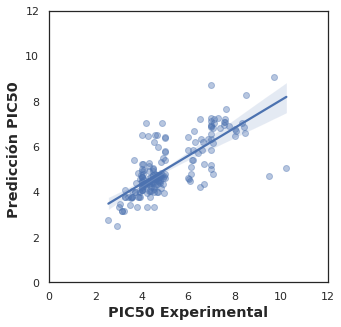

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('PIC50 Experimental', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicción PIC50 ', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

In [ ]:
! unzip padel.zip -y

Archive:  padel.zip
caution: filename not matched:  -y


##Implementar Segundos descriptores

In [ ]:
from pandas.io.parsers.readers import read_csv
df3_selection = read_csv('molecule.csv', sep = ';')
df3_selection

,canonical_smile,chembl_id
0,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,CHEMBL55
1,CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...,CHEMBL2069130
2,CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC...,CHEMBL3138270
3,OC1(Cc2ccccc2)c2ccccc2C2=NCCN21,CHEMBL66573
4,COc1ccc(C(=O)C(=O)c2ccccc2C(=O)N2CCCCC2)cc1OC,CHEMBL303106
...,...,...
989,COc1ccc(OC)c2c1Cn1cccc1C2(C)CC#N,CHEMBL4876767
990,CC1(CC#N)c2ccc(F)cc2Cn2cccc21,CHEMBL4878509
991,COc1ccc2c(c1)Cn1cccc1C2(C)CC#N,CHEMBL4870180
992,CC1(CC#N)c2ccc(OCc3ccccc3)cc2Cn2cccc21,CHEMBL4871294


In [ ]:
!pip install rdkit-pypi
!pip install mordred

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# https://pandas.pydata.org
import pandas as pd

# https://numpy.org/doc/stable/release.html
import numpy as np

#https://github.com/mordred-descriptor/mordred
from mordred import Calculator, descriptors


def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors, desc_names = RDkit_descriptors(df3_selection['canonical_smile'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_with_208_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_208_descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.256827,-4.423817,8.256827,0.327767,0.301958,340.427,316.235,340.189926,132,0,...,0,0,0,0,0,0,0,0,0,0
1,10.287662,-6.427612,10.287662,1.654344,0.614583,403.651,358.291,403.345030,166,0,...,0,0,0,0,0,0,0,0,0,0
2,15.031610,-9.024384,15.031610,2.104340,0.335153,573.979,510.475,573.457721,230,0,...,0,0,0,0,0,0,0,0,0,0
3,8.952981,-3.513660,8.952981,0.215627,0.901870,264.328,248.200,264.126263,100,0,...,0,0,0,0,0,0,0,0,0,0
4,14.037159,-4.215874,14.037159,0.865648,0.566433,381.428,358.244,381.157623,146,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,9.836123,-3.900445,9.836123,0.079459,0.868797,282.343,264.199,282.136828,108,0,...,0,0,0,0,0,0,0,0,0,0
990,14.519457,-3.657963,14.519457,0.182618,0.752027,240.281,227.177,240.106277,90,0,...,0,0,0,0,0,0,0,0,0,0
991,9.672988,-3.705016,9.672988,0.182299,0.823397,252.317,236.189,252.126263,96,0,...,0,0,0,0,0,0,0,0,0,0
992,9.860595,-3.818233,9.860595,0.121614,0.699045,328.415,308.255,328.157563,124,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

clean_dataset(df_with_208_descriptors)


from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X6 = selection.fit_transform(df_with_208_descriptors)

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X6_train, X6_test, Y6_train, Y6_test = train_test_split(X6, Y, test_size=0.2,random_state=10)


model = RandomForestRegressor(n_estimators=120, max_depth=8, random_state=0, criterion='squared_error',  min_samples_split=4)
model.fit(X6_train, Y6_train)
r6 = model.score(X6_test, Y6_test)
r6

ValueError: ignored

In [ ]:
def morgan_fpts(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i) 
        fpts =  AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)  
    return np.array(Morgan_fpts)

In [ ]:
Morgan_fpts = morgan_fpts(df3_selection['canonical_smile'])
Morgan_fpts.shape

(994, 2048)

In [ ]:
Morgan_fingerprints = pd.DataFrame(Morgan_fpts,columns=['Des_{}'.format(i) for i in range(Morgan_fpts.shape[1])])
Morgan_fingerprints

,Des_0,Des_1,Des_2,Des_3,Des_4,Des_5,Des_6,Des_7,Des_8,Des_9,...,Des_2038,Des_2039,Des_2040,Des_2041,Des_2042,Des_2043,Des_2044,Des_2045,Des_2046,Des_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
df5 = pd.concat([Morgan_fingerprints, df3_Y], axis=1)
df5

,Des_0,Des_1,Des_2,Des_3,Des_4,Des_5,Des_6,Des_7,Des_8,Des_9,...,Des_2039,Des_2040,Des_2041,Des_2042,Des_2043,Des_2044,Des_2045,Des_2046,Des_2047,pIC50
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.318759
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.000000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.988007
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.221849
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.027566
990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.015248
991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.909213
992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,4.800519


In [ ]:
df5.to_csv('leishmaniasis_07_bioactivity_data_3class_pIC50_morgan_fp.csv', index=False)

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df6 = pd.read_csv('leishmaniasis_07_bioactivity_data_3class_pIC50_pubchem_fp.csv')

In [ ]:
X4 = df6.drop('pIC50', axis=1)
X4

,Des_0,Des_1,Des_2,Des_3,Des_4,Des_5,Des_6,Des_7,Des_8,Des_9,...,Des_2038,Des_2039,Des_2040,Des_2041,Des_2042,Des_2043,Des_2044,Des_2045,Des_2046,Des_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
Y4 = df6.pIC50
Y4

0      6.318759
1      7.000000
2      4.988007
3      7.221849
4      7.000000
         ...   
989    4.027566
990    4.015248
991    3.909213
992    4.800519
993    4.605198
Name: pIC50, Length: 994, dtype: float64

Eliminar varianzas bajas

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X4 = selection.fit_transform(X4)

In [ ]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X4_train, X4_test, Y4_train, Y4_test = train_test_split(X4, Y4, test_size=0.2,random_state=10)

##Primer Modelo Segundo Descriptor

In [ ]:
model = RandomForestRegressor(n_estimators=120, max_depth=8, random_state=0, criterion='squared_error',  min_samples_split=4)
model.fit(X4_train, Y4_train)
r2 = model.score(X4_test, Y4_test)
r2

0.5377377409285966

In [ ]:
#Segundo Modelo
from sklearn.neural_network import MLPRegressor
Modelo3=MLPRegressor(random_state=4, max_iter=800, hidden_layer_sizes=(60,), activation='relu').fit(X4_train,Y4_train)
Modelo3.score(X4_test,Y4_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.44375385738317297

In [ ]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    # pandas df
    df = calc.pandas(mols)
    return df

In [ ]:
df3_selection

,canonical_smile,chembl_id
0,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,CHEMBL55
1,CC(O)(C1CCCCN1)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H...,CHEMBL2069130
2,CCC(=O)N1CCCCC1C(C)(O)[C@H]1CC[C@H]2[C@@H]3CCC...,CHEMBL3138270
3,OC1(Cc2ccccc2)c2ccccc2C2=NCCN21,CHEMBL66573
4,COc1ccc(C(=O)C(=O)c2ccccc2C(=O)N2CCCCC2)cc1OC,CHEMBL303106
...,...,...
989,COc1ccc(OC)c2c1Cn1cccc1C2(C)CC#N,CHEMBL4876767
990,CC1(CC#N)c2ccc(F)cc2Cn2cccc21,CHEMBL4878509
991,COc1ccc2c(c1)Cn1cccc1C2(C)CC#N,CHEMBL4870180
992,CC1(CC#N)c2ccc(OCc3ccccc3)cc2Cn2cccc21,CHEMBL4871294


In [ ]:
mordred_descriptors = All_Mordred_descriptors(df3_selection['canonical_smile'])

 13%|█▎        | 129/994 [01:38<15:49,  1.10s/it]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 33%|███▎      | 324/994 [04:19<11:56,  1.07s/it]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 994/994 [13:08<00:00,  1.26it/s]


In [ ]:
mordred_descriptors
mordred_descriptors.replace(np.nan, 0)
#mordred_descriptors.to_csv('mordred_X5.csv', index = False)

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,18.741455,13.609809,0,4,31.462873,2.261616,4.523232,31.462873,1.258515,4.108088,...,9.710691,58.711279,340.189926,6.942652,2120,32,118.0,130.0,8.416667,5.722222
1,23.629050,18.180034,0,1,37.864954,2.637904,5.221840,37.864954,1.305688,4.342817,...,10.824308,80.284783,403.345030,5.450609,2054,61,172.0,217.0,9.465278,5.972222
2,32.026204,24.451587,0,0,49.787155,2.642900,5.233230,49.787155,1.244679,4.642342,...,11.101779,92.739627,573.457721,5.567551,5368,84,232.0,289.0,16.062500,8.215278
3,16.177835,13.616762,0,2,27.002129,2.607285,4.997442,27.002129,1.350106,3.973380,...,10.215631,70.885765,264.126263,7.336841,728,34,114.0,141.0,4.868056,4.291667
4,21.258292,17.546744,0,0,36.944337,2.426386,4.852773,36.944337,1.319441,4.247113,...,10.214679,63.236942,381.157623,7.473679,2070,47,142.0,168.0,9.500000,6.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,16.137395,14.440179,0,0,27.156343,2.589528,5.149813,27.156343,1.293159,3.990431,...,10.320123,69.339785,282.136828,7.234278,779,40,114.0,142.0,7.229167,4.819444
990,14.206345,12.406303,0,0,22.997445,2.557563,5.077852,22.997445,1.277636,3.849821,...,10.155452,65.628394,240.106277,7.745364,525,32,100.0,123.0,5.868056,3.930556
991,14.804062,12.869025,0,0,24.685944,2.559050,5.081459,24.685944,1.299260,3.897398,...,10.180475,66.798407,252.126263,7.203608,625,34,104.0,128.0,6.118056,4.263889
992,19.753809,15.329934,0,0,33.140293,2.559723,5.083185,33.140293,1.325612,4.169406,...,10.337767,73.924091,328.157563,7.292390,1537,42,136.0,164.0,6.729167,5.513889


Eliminar varianzas bajas

In [ ]:
Y5 = df6.pIC50
Y5



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


In [ ]:
X5.shape

(994, 784)

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

X5 = clean_dataset(mordred_descriptors)

from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X5 = selection.fit_transform(X5)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


In [ ]:
#dividir conjunto de datos 80/20
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X5_train, X5_test, Y5_train, Y5_test = train_test_split(X5, Y5, test_size=0.2,random_state=10)

In [ ]:
model = RandomForestRegressor(n_estimators=70, max_depth=8, random_state=0,  min_samples_split=3)
model.fit(X5_train, Y5_train)
r3 = model.score(X5_test, Y5_test)
#puntaje
r3

In [ ]:
mordred_descriptors = All_Mordred_descriptors(df3_selection['canonical_smiles'])

 13%|█▎        | 129/994 [01:35<17:50,  1.24s/it]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 32%|███▏      | 323/994 [04:09<13:08,  1.17s/it]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 994/994 [12:32<00:00,  1.32it/s]


In [ ]:
mordred_descriptors.to_csv('mordred_descriptors_leishmaniasis.csv', index = False)

In [ ]:
mordred_descriptors

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,18.741455,13.609809,0,4,31.462873,2.261616,4.523232,31.462873,1.258515,4.108088,...,9.710691,58.711279,340.189926,6.942652,2120,32,118.0,130.0,8.416667,5.722222
1,23.629050,18.180034,0,1,37.864954,2.637904,5.221840,37.864954,1.305688,4.342817,...,10.824308,80.284783,403.345030,5.450609,2054,61,172.0,217.0,9.465278,5.972222
2,32.026204,24.451587,0,0,49.787155,2.642900,5.233230,49.787155,1.244679,4.642342,...,11.101779,92.739627,573.457721,5.567551,5368,84,232.0,289.0,16.062500,8.215278
3,16.177835,13.616762,0,2,27.002129,2.607285,4.997442,27.002129,1.350106,3.973380,...,10.215631,70.885765,264.126263,7.336841,728,34,114.0,141.0,4.868056,4.291667
4,21.258292,17.546744,0,0,36.944337,2.426386,4.852773,36.944337,1.319441,4.247113,...,10.214679,63.236942,381.157623,7.473679,2070,47,142.0,168.0,9.500000,6.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,16.137395,14.440179,0,0,27.156343,2.589528,5.149813,27.156343,1.293159,3.990431,...,10.320123,69.339785,282.136828,7.234278,779,40,114.0,142.0,7.229167,4.819444
990,14.206345,12.406303,0,0,22.997445,2.557563,5.077852,22.997445,1.277636,3.849821,...,10.155452,65.628394,240.106277,7.745364,525,32,100.0,123.0,5.868056,3.930556
991,14.804062,12.869025,0,0,24.685944,2.559050,5.081459,24.685944,1.299260,3.897398,...,10.180475,66.798407,252.126263,7.203608,625,34,104.0,128.0,6.118056,4.263889
992,19.753809,15.329934,0,0,33.140293,2.559723,5.083185,33.140293,1.325612,4.169406,...,10.337767,73.924091,328.157563,7.292390,1537,42,136.0,164.0,6.729167,5.513889
